In [1]:
pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from math import sin, cos, sqrt, atan2, radians

import warnings
warnings.filterwarnings("ignore")

In [4]:
Entregas = pd.read_excel('Entregas.xlsx', index_col="Cliente" )
Entregas.head(10)
#print(Entregas.iloc[-1])

,Latitud,Longitud,Unidades
Cliente,,,
El Fuerte Villa Zaita,9.076953,-79.523970,20
Supermercado rey Milla 8,9.071359,-79.515842,30
Los Andes Mall,9.054300,-79.507796,25
El Crisol,9.044528,-79.471662,15
FD-Center,9.025230,-79.509758,10
Artec,9.032901,-79.511732,15


### VRP usando GORUBI

In [5]:
# Crear una cuadrado con limites de nuestro mapa
bbox = (Entregas.Longitud.min(), Entregas.Longitud.max(), 
        Entregas.Latitud.min(), Entregas.Latitud.max())
bbox

(-79.52396987266873, -79.47166249822219, 9.02522951905493, 9.07695323086607)

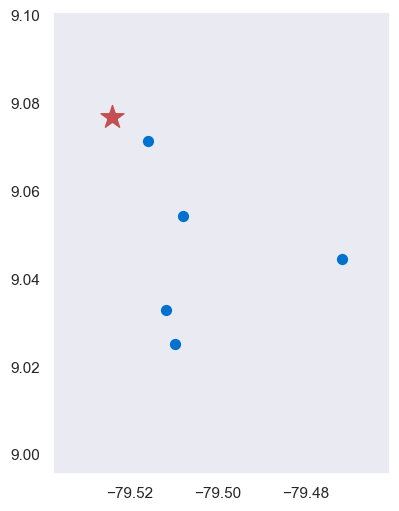

In [7]:
# Dibujar la bodega y los clientes
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(Entregas.Longitud, Entregas.Latitud, 
           zorder=1, c='#0072ce', s=50)
ax.scatter(Entregas.iloc[0].Longitud,
           Entregas.iloc[0].Latitud,  marker="*", c='r', s=300)
# Set x,y limits
ax.set_xlim(-79.53750737115854,-79.46087578300474)
ax.set_ylim(8.995651387228135,9.100794217041744)
ax.imshow(Entregas,extent=(0.0728,0.1509,52.18,52.2324),aspect='equal')
ax.grid(False)

In [8]:
n = 5  # numero de clientes

In [9]:
from math import sin, cos, sqrt, atan2, radians
def distance(i, j):
    #for i, j in A:
# aproximación del radio de la tierra en km
        R = 6373.0

        lat1 = radians(Entregas.Latitud[i])
        lon1 = radians(Entregas.Longitud[i])
        lat2 = radians(Entregas.Latitud[j])
        lon2 = radians(Entregas.Longitud[j])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        return R * c

#print("Result:", distance)
#print("Should be:", 278.546, "km")

In [10]:
# aproximación del radio de la tierra en km
R = 6373.0

N = [i for i in range(1, n+1)] #Set de clientes
V = [0] + N # set de nodos
A = [(i, j) for i in V for j in V if i != j] #Set de arcos
c = {(i, j): distance(i, j) for i, j in A} #Costo de viajar por estos arcos (En nuestro caso es la distancia)
Q = 40 #Capacidad de los vehículos
q = {i: Entregas.Unidades[i] for i in N} #La demanda de cada cliente
#print(A)
print(c)

{(0, 1): 1.088178429393563, (0, 2): 3.083053140226588, (0, 3): 6.783729368328147, (0, 4): 5.9612664099307615, (0, 5): 5.080982940982148, (1, 0): 1.088178429393563, (1, 2): 2.093250744351599, (1, 3): 5.6970555699027905, (1, 4): 5.174352786279583, (1, 5): 4.301476778273124, (2, 0): 3.083053140226588, (2, 1): 2.093250744351599, (2, 3): 4.11521245186654, (2, 4): 3.240657525890884, (2, 5): 2.4191401896132554, (3, 0): 6.783729368328147, (3, 1): 5.6970555699027905, (3, 2): 4.11521245186654, (3, 4): 4.703185503303773, (3, 5): 4.587624297350155, (4, 0): 5.9612664099307615, (4, 1): 5.174352786279583, (4, 2): 3.240657525890884, (4, 3): 4.703185503303773, (4, 5): 0.8804169906405367, (5, 0): 5.080982940982148, (5, 1): 4.301476778273124, (5, 2): 2.4191401896132554, (5, 3): 4.587624297350155, (5, 4): 0.8804169906405367}


In [11]:
from gurobipy import Model, GRB, quicksum

In [12]:
mdl = Model('CVRP')

Restricted license - for non-production use only - expires 2024-10-28


In [13]:
x = mdl.addVars(A, vtype=GRB.BINARY) #Agregar arcos al modelo
u = mdl.addVars(N, vtype=GRB.CONTINUOUS) #Agregar clientes

In [14]:
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A))

In [15]:
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
               for i, j in A if i != 0 and j != 0)
mdl.addConstrs(u[i] >= q[i] for i in N)
mdl.addConstrs(u[i] <= Q for i in N)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

In [16]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 30  # seconds
mdl.optimize()

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 35 columns and 60 nonzeros
Model fingerprint: 0xf9c32a04
Model has 20 general constraints
Variable types: 5 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
  GenCon rhs range [1e+01, 3e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 10 rows and 0 columns
Presolve removed 0 rows and 14 columns
Presolve time: 0.02s
Presolved: 30 rows, 21 columns, 143 nonzeros
Variable types: 7 continuous, 14 integer (14 binary)
Found heuristic solution: objective 36.3677585

Root relaxation: objective 1.851369e+01, 12 iterations, 0

In [17]:
active_arcs = [a for a in A if x[a].x > 0.99]

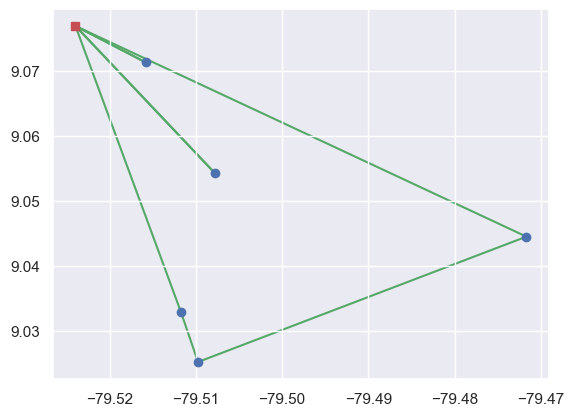

In [18]:
#for i in range(Entregas.shape[0]):
#    plt.text(x=np.log(Entregas.Latitud[i]),y=np.log(Entregas.Longitud[i]),s=Entregas.Unidades[i])
for i, j in active_arcs:
    plt.plot( [Entregas.Longitud[i], Entregas.Longitud[j]],[Entregas.Latitud[i], Entregas.Latitud[j]], c='g', zorder=0)
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (Entregas.Longitud[i]+2, Entregas.Latitud[i]))
plt.plot(Entregas.Longitud[0], Entregas.Latitud[0], c='r', marker='s')
plt.scatter( Entregas.Longitud[1:], Entregas.Latitud[1:], c='b')
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (Entregas.Longitud[i]+2, Entregas.Latitud[i]))